In [1]:
from pathlib import Path
import itertools
from functools import reduce
import os

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm


from lobib import DataLoader

sns.set_style("whitegrid")
rng = np.random.default_rng(1337)

os.makedirs("../figures/fit", exist_ok=True)

def save_fig(name):
    plt.savefig(f"../figures/fit/{name}.pdf", bbox_inches='tight')
    plt.savefig(f"../figures/fit/{name}.png", bbox_inches='tight', dpi=150)

In [2]:
loader = DataLoader()

def pl_select(condlist: list[pl.Expr], choicelist: list[pl.Expr]) -> pl.Expr:
    return reduce(
        lambda expr, cond_choice: expr.when(cond_choice[0]).then(cond_choice[1]),
        zip(condlist, choicelist),
        pl.when(condlist[0]).then(choicelist[0]),
    )

def imbalance_exp() -> tuple[pl.Expr, pl.Expr]:
    condlist = [pl.col("best_bid_nbr").eq(-i) for i in range(1, 11)]
    choicelist = [pl.col(f"Q_{-i}") for i in range(1, 11)]
    best_bid = pl_select(condlist, choicelist).alias("best_bid").truediv(500).ceil()
    
    condlist = [pl.col("best_ask_nbr").eq(i) for i in range(1, 11)]
    choicelist = [pl.col(f"Q_{i}") for i in range(1, 11)]
    best_ask = pl_select(condlist, choicelist).alias("best_ask").truediv(500).ceil()
    imb = ((best_bid - best_ask) / (best_bid + best_ask)).alias("imb")

    bins = np.arange(11, step=1) / 10
    condlist = [
        *[
            pl.col("imb").ge(left) & pl.col("imb").lt(right)
            for left, right in zip(-bins[1:][::-1], -bins[:-1][::-1])
        ],
        pl.col("imb").eq(0),
        *[
            pl.col("imb").gt(left) & pl.col("imb").le(right)
            for left, right in zip(bins[:-1], bins[1:])
        ],
    ]
    choicelist = [*(-bins[1:][::-1]), 0, *bins[1:]]
    imb_bin = pl_select(condlist, choicelist).alias("imb_bin")
    return imb, imb_bin
    
def load_ticker(ticker: str) -> pl.DataFrame:
    info = loader.ticker_info("AAL")
    df = loader.load(
        "AAL",
        start_date=info["date"].min(),
        end_date=info["date"].max(),
        schema="qr",
        eager=True,
    ).sort(["date", "ts_event"])
    df = df.filter(
        (
            pl.col("event_side")
            .replace({"A": 1, "B": -1})
            .cast(int)
            .mul(pl.col("event_queue_nbr"))
            >= 0
        )
    )
    df = df.with_columns(pl.col("event").replace({"Trd_All": "Trd"}))
    df = df.with_columns(
        pl.when(pl.col("event_queue_nbr").lt(0))
        .then(pl.col("event_queue_nbr").sub(pl.col("best_bid_nbr")).sub(1))
        .otherwise(pl.col("event_queue_nbr").sub(pl.col("best_ask_nbr")).add(1))
        .alias("event_q")
    )
    imb, imb_bin = imbalance_exp()
    df = df.with_columns(imb).with_columns(imb_bin)
    df = df.filter(pl.col("event_q").abs().le(2))
    df = df.with_columns(pl.when(pl.col("spread").ge(2)).then(2).otherwise(pl.col("spread")).alias("spread"))
    df = df.with_columns(pl.col("P_1").add(pl.col("P_-1")).truediv(2).alias("mid"))
    return df 

def compute_dt(df: pl.DataFrame) -> pl.DataFrame:
    dt = df.select(pl.col("ts_event").diff().over("date").cast(int).alias("dt"), "imb_bin", "spread").filter(pl.col("dt").gt(0))
    dt = dt.with_columns(pl.col("dt").log10().alias("dt_log"))
    return dt

def compute_eta(df: pl.DataFrame, date_col: str = "date", mid_col: str = "mid") -> pl.DataFrame:
  """Compute eta per trading day."""
  return (
      df
      .with_columns(
          pl.col(mid_col).diff().over(date_col).alias("mid_diff")
      )
      .with_columns(
          pl.col("mid_diff").sign().alias("sign"),
          pl.col("mid_diff").sign().shift(1).over(date_col).alias("prev_sign")
      )
      .filter(pl.col("mid_diff").ne(0) & pl.col("prev_sign").is_not_null() & pl.col("prev_sign").ne(0))
      .with_columns(
          (pl.col("sign") == pl.col("prev_sign")).alias("is_continuation"),
          (pl.col("sign") != pl.col("prev_sign")).alias("is_alternation")
      )
      .group_by(date_col)
      .agg(
          pl.col("is_continuation").sum().alias("n_continuations"),
          pl.col("is_alternation").sum().alias("n_alternations")
      )
      .with_columns(
          (pl.col("n_continuations") / (2 * pl.col("n_alternations"))).alias("eta")
      )
  )

def compute_volatility(df: pl.DataFrame) -> pl.DataFrame:
  """Compute volatility (sum of squared mid differences) per trading day."""
  return (
      df
      .with_columns(pl.col("mid").diff().over("date").alias("mid_diff"))
      .filter(pl.col("mid_diff").is_not_null())
      .group_by("date")
      .agg((pl.col("mid_diff") ** 2).mean().alias("volatility"))
  )

In [3]:
ticker = "AAL"
df = load_ticker(ticker)
df = df.with_columns(pl.col("ts_event").diff().over("date").cast(int).alias("dt"))
dt = compute_dt(df)

In [4]:
DAY_NS = int(5.5 * 3600 * 1e9)  # 5.5 hours in nanoseconds
HOUR_NS = int(3600 * 1e9)

dfer = pl.read_parquet("../data/results/result_alpha_ema_impact_k1.0_race.parquet")
dfenr = pl.read_parquet("../data/results/result_alpha_no_impact_k1.0_norace.parquet")
dfer = dfer.with_columns(
  (pl.col("ts_event") // DAY_NS).alias("date")
)
dfenr = dfenr.with_columns(
  (pl.col("ts_event") // DAY_NS).alias("date")
)
dfe = dfer.filter(~pl.col("rejected"))
dfen = dfenr.filter(~pl.col("rejected"))
imb, imb_bin = imbalance_exp()
dfe = dfe.with_columns(imb_bin)
dfen = dfen.with_columns(imb_bin)

In [5]:
dfe = dfe.with_columns(pl.col("ts_event").diff().alias("dt"))
dte = dfe.select("dt").filter(pl.col("dt").gt(0)).with_columns(pl.col("dt").log10().alias("dt_log"))

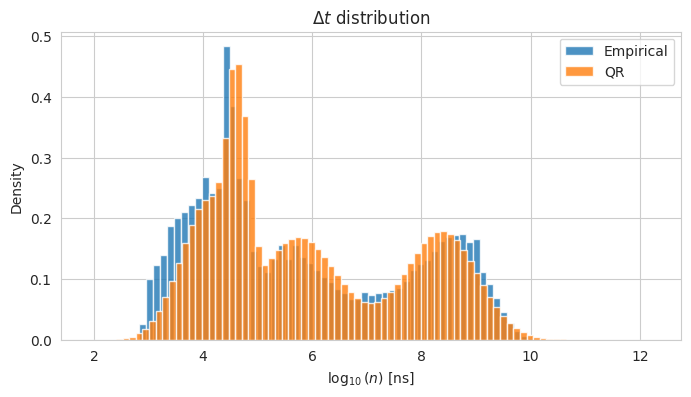

In [6]:
plt.figure(figsize=(8, 4))

plt.hist(dt["dt_log"], bins=80, label="Empirical", density=True, alpha=.8)
plt.hist(dte["dt_log"], bins=80, label="QR", density=True, alpha=.8)

plt.ylabel("Density")
plt.xlabel(r"$\log_{10}(n)\text{ [ns] }$")
plt.title(r"$\Delta t$ distribution")
plt.legend()
save_fig("dt_distribution")
plt.show()

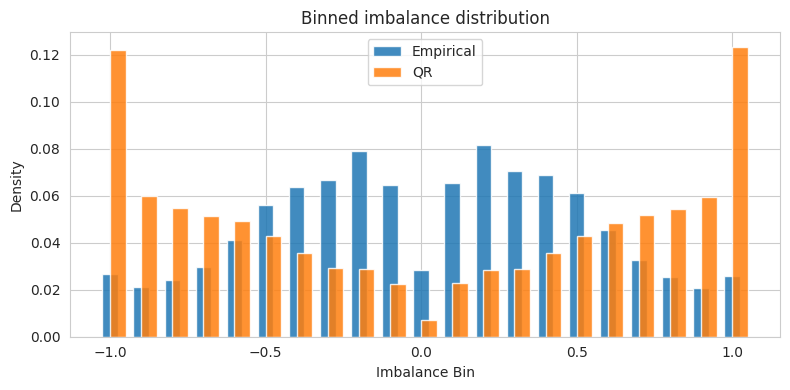

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))

imbf = df["imb_bin"].value_counts(normalize=True).sort("imb_bin")
imbfe = dfe["imb_bin"].value_counts(normalize=True).sort("imb_bin")

x = imbf["imb_bin"]
width = 0.05

ax.bar(x, imbf["proportion"], width, label="Empirical", alpha=0.85)
ax.bar(x + width/2, imbfe["proportion"], width, label="QR", alpha=0.85)

ax.set_xlabel("Imbalance Bin")
ax.set_ylabel("Density")
ax.legend()
ax.set_title("Binned imbalance distribution")

plt.tight_layout()
save_fig("imbalance_distribution")
plt.show()

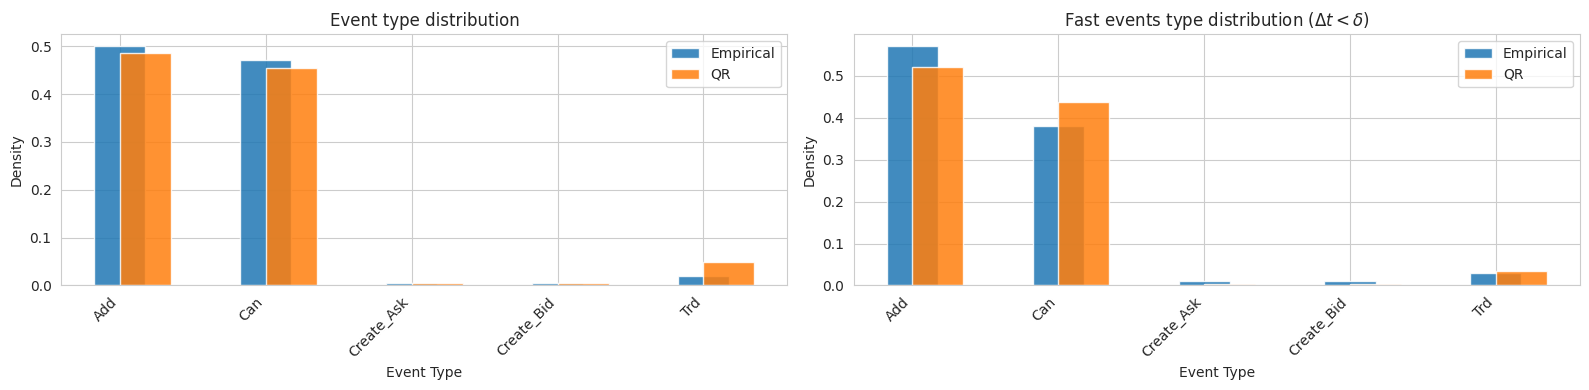

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

imbf = df["event"].value_counts(normalize=True).sort("event")
imbfe = dfe["event"].value_counts(normalize=True).sort("event")

labels = imbf["event"]
x = np.arange(len(labels))
width = 0.35

ax1.bar(x , imbf["proportion"], width, label="Empirical", alpha=0.85)
ax1.bar(x + width/2, imbfe["proportion"], width, label="QR", alpha=0.85)

ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.set_xlabel("Event Type")
ax1.set_ylabel("Density")
ax1.legend()
ax1.set_title("Event type distribution")

imbf = df.filter(pl.col("dt").gt(0) & pl.col("dt").log10().lt(4.4))["event"].value_counts(normalize=True).sort("event")
imbfe = dfe.filter(pl.col("dt").gt(0) & pl.col("dt").log10().lt(4.4))["event"].value_counts(normalize=True).sort("event")

labels = imbf["event"]
x = np.arange(len(labels))
width = 0.35

ax2.bar(x , imbf["proportion"], width, label="Empirical", alpha=0.85)
ax2.bar(x + width/2, imbfe["proportion"], width, label="QR", alpha=0.85)

ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.set_xlabel("Event Type")
ax2.set_ylabel("Density")
ax2.legend()
ax2.set_title(r"Fast events type distribution $(\Delta t < \delta)$")

plt.tight_layout()
save_fig("event_type_distribution")
plt.show()

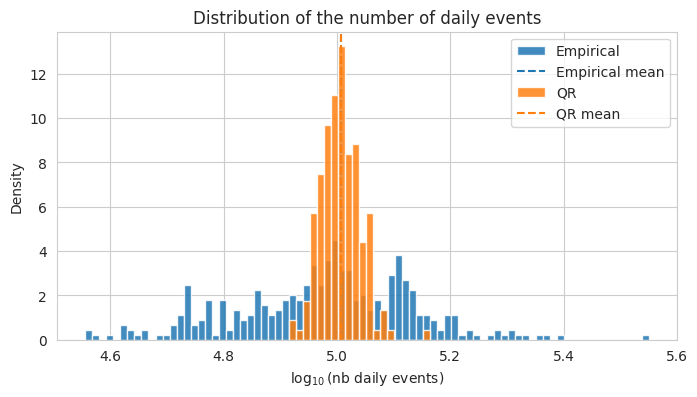

In [9]:
plt.figure(figsize=(8, 4))

plt.hist(df.group_by("date").len().with_columns(pl.col("len").log10())["len"], bins=80, label="Empirical", alpha=.85, density=True)
plt.axvline(np.log10(df.group_by("date").len()["len"].mean()), label="Empirical mean", linestyle="--")
plt.hist(dfe.group_by("date").len().with_columns(pl.col("len").log10())["len"], bins=20, label="QR", alpha=.85, density=True)
plt.axvline(np.log10(dfe.group_by("date").len()["len"].mean()), label="QR mean", linestyle="--", color="tab:orange")


plt.title("Distribution of the number of daily events")
plt.xlabel(r"$\log_{10}(\text{nb daily events})$")
plt.ylabel("Density")
plt.legend()
save_fig("daily_events")
plt.show()

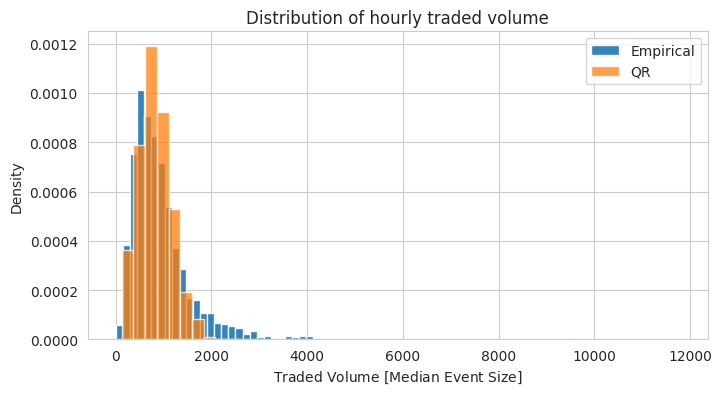

In [10]:
plt.figure(figsize=(8, 4))

sz = df.filter(pl.col("event").eq("Trd")).group_by(pl.col("date"), pl.col("ts_event").dt.hour()).agg(pl.col("event_size").truediv(500).ceil().cast(int).sum())["event_size"]
sze = dfe.filter(pl.col("event").eq("Trade")).group_by(pl.col("date"), pl.col("ts_event")//HOUR_NS).agg(pl.col("event_size").truediv(500).ceil().cast(int).sum())["event_size"]

plt.hist(sz, bins=80, label="Empirical", alpha=.9, density=True)
plt.hist(sze, bins=10, label="QR", alpha=.75, density=True)

plt.title("Distribution of hourly traded volume")
plt.xlabel(r"$\text{Traded Volume}$ [Median Event Size]")
plt.ylabel("Density")
plt.legend()
save_fig("hourly_volume")
plt.show()

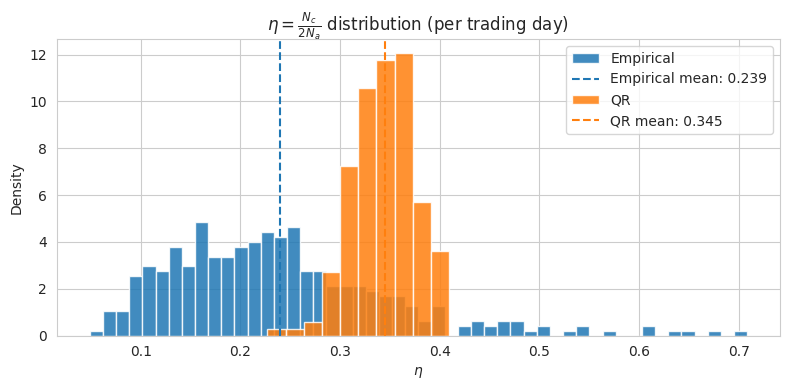

In [11]:
# Compute and plot eta
eta_emp = compute_eta(df, date_col="date", mid_col="mid")
eta_qr = compute_eta(dfe, date_col="date", mid_col="mid")

plt.figure(figsize=(8, 4))

plt.hist(eta_emp["eta"], bins=50, label="Empirical", alpha=0.85, density=True)
plt.axvline(eta_emp["eta"].mean(), linestyle="--", color="tab:blue", label=f"Empirical mean: {eta_emp['eta'].mean():.3f}")
plt.hist(eta_qr["eta"], bins=10, label="QR", alpha=0.85, density=True)
plt.axvline(eta_qr["eta"].mean(), linestyle="--", color="tab:orange", label=f"QR mean: {eta_qr['eta'].mean():.3f}")

plt.title(r"$\eta = \frac{N_c}{2 N_a}$ distribution (per trading day)")
plt.xlabel(r"$\eta$")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
save_fig("eta_distribution")
plt.show()

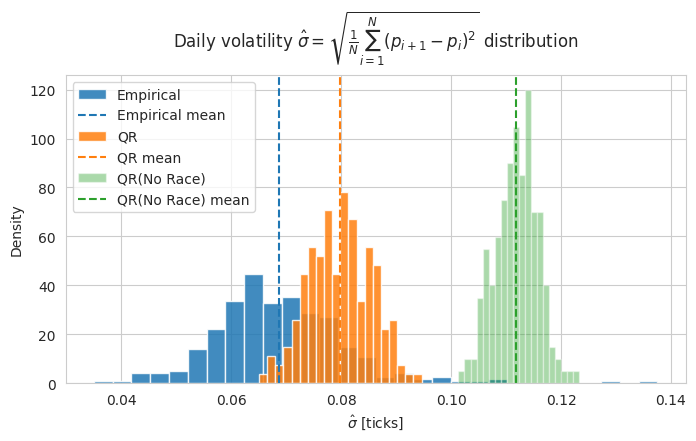

In [12]:
vol_emp = compute_volatility(df)
vol_qr = compute_volatility(dfe)
vol_qrn = compute_volatility(dfen)

plt.figure(figsize=(8, 4))

plt.hist(vol_emp["volatility"].sqrt(), bins=30, label="Empirical", alpha=0.85, density=True)
plt.axvline(vol_emp["volatility"].sqrt().mean(), linestyle="--", color="tab:blue", label="Empirical mean")
plt.hist(vol_qr["volatility"].sqrt(), bins=20, label="QR", alpha=0.85, density=True)
plt.axvline(vol_qr["volatility"].sqrt().mean(), linestyle="--", color="tab:orange", label="QR mean")
plt.hist(vol_qrn["volatility"].sqrt(), bins=20, label="QR(No Race)", alpha=0.4, density=True)
plt.axvline(vol_qrn["volatility"].sqrt().mean(), linestyle="--", color="tab:green", label="QR(No Race) mean")

plt.title(r"Daily volatility $\hat\sigma = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(p_{i+1} - p_i)^2}$ distribution", pad=20)
plt.xlabel(r"$\hat\sigma$ [ticks]")
plt.ylabel("Density")
plt.legend()
save_fig("volatility_distribution")
plt.show()

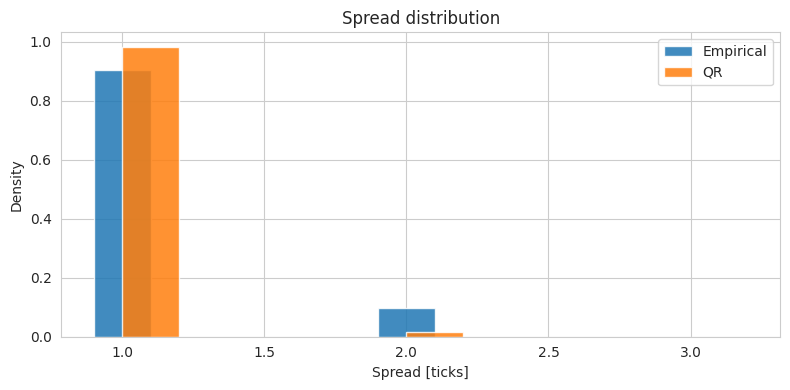

In [13]:
# Spread distribution
fig, ax = plt.subplots(figsize=(8, 4))

spread_emp = df["spread"].value_counts(normalize=True).sort("spread")
spread_qr = dfe.with_columns((pl.col("P_1") - pl.col("P_-1")).alias("spread"))["spread"].value_counts(normalize=True).sort("spread")

x = spread_emp["spread"]
width = 0.2

ax.bar(x, spread_emp["proportion"], width, label="Empirical", alpha=0.85)
ax.bar(spread_qr["spread"] + width/2, spread_qr["proportion"], width, label="QR", alpha=0.85)

ax.set_xlabel("Spread [ticks]")
ax.set_ylabel("Density")
ax.legend()
ax.set_title("Spread distribution")

plt.tight_layout()
save_fig("spread_distribution")
plt.show()

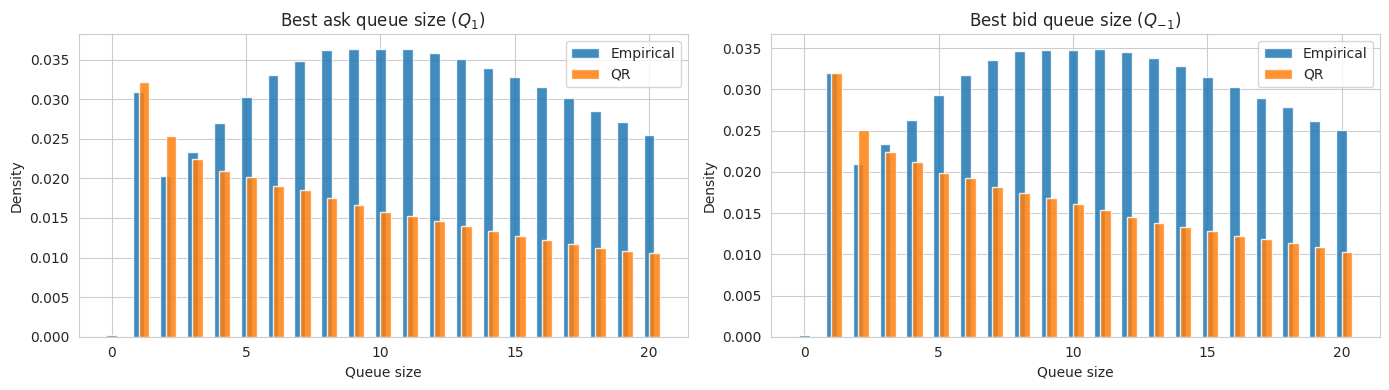

In [14]:
# Queue size at BBO distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Q_1 (best ask)
q1_emp = df.select(pl.col("Q_1").truediv(500).ceil().cast(int))["Q_1"].value_counts(normalize=True).sort("Q_1").filter(pl.col("Q_1").le(20))
q1_qr = dfe["Q_1"].value_counts(normalize=True).sort("Q_1").filter(pl.col("Q_1").le(20))

ax1.bar(q1_emp["Q_1"], q1_emp["proportion"], 0.4, label="Empirical", alpha=0.85)
ax1.bar(q1_qr["Q_1"] + 0.2, q1_qr["proportion"], 0.4, label="QR", alpha=0.85)
ax1.set_xlabel("Queue size")
ax1.set_ylabel("Density")
ax1.set_title("Best ask queue size ($Q_1$)")
ax1.legend()

# Q_-1 (best bid)
qm1_emp = df.select(pl.col("Q_-1").truediv(500).ceil().cast(int))["Q_-1"].value_counts(normalize=True).sort("Q_-1").filter(pl.col("Q_-1").le(20))
qm1_qr = dfe["Q_-1"].value_counts(normalize=True).sort("Q_-1").filter(pl.col("Q_-1").le(20))

ax2.bar(qm1_emp["Q_-1"], qm1_emp["proportion"], 0.4, label="Empirical", alpha=0.85)
ax2.bar(qm1_qr["Q_-1"] + 0.2, qm1_qr["proportion"], 0.4, label="QR", alpha=0.85)
ax2.set_xlabel("Queue size")
ax2.set_ylabel("Density")
ax2.set_title("Best bid queue size ($Q_{-1}$)")
ax2.legend()

plt.tight_layout()
save_fig("queue_size_distribution")
plt.show()

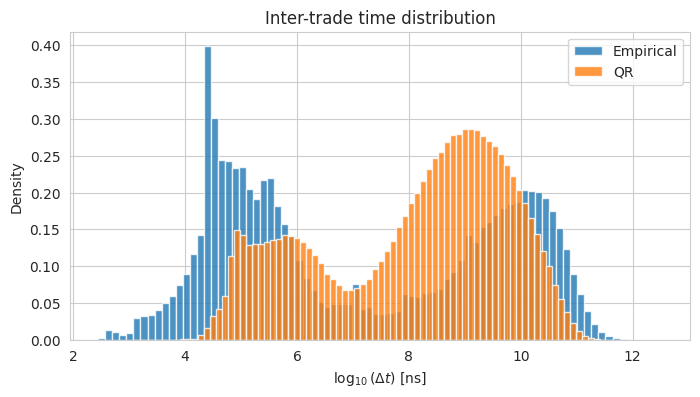

In [15]:
# Inter-trade time distribution
plt.figure(figsize=(8, 4))

dt_trades_emp = (
    df.filter(pl.col("event").eq("Trd"))
    .with_columns(pl.col("ts_event").diff().over("date").cast(int).alias("dt"))
    .filter(pl.col("dt").gt(0))
    .with_columns(pl.col("dt").log10().alias("dt_log"))
)

dt_trades_qr = (
    dfe.filter(pl.col("event").eq("Trade"))
    .with_columns(pl.col("ts_event").diff().over("date").cast(int).alias("dt"))
    .filter(pl.col("dt").gt(0))
    .with_columns(pl.col("dt").log10().alias("dt_log"))
)

plt.hist(dt_trades_emp["dt_log"], bins=80, label="Empirical", density=True, alpha=.8)
plt.hist(dt_trades_qr["dt_log"], bins=80, label="QR", density=True, alpha=.8)

plt.ylabel("Density")
plt.xlabel(r"$\log_{10}(\Delta t)\text{ [ns]}$")
plt.title(r"Inter-trade time distribution")
plt.legend()
save_fig("inter_trade_time")
plt.show()

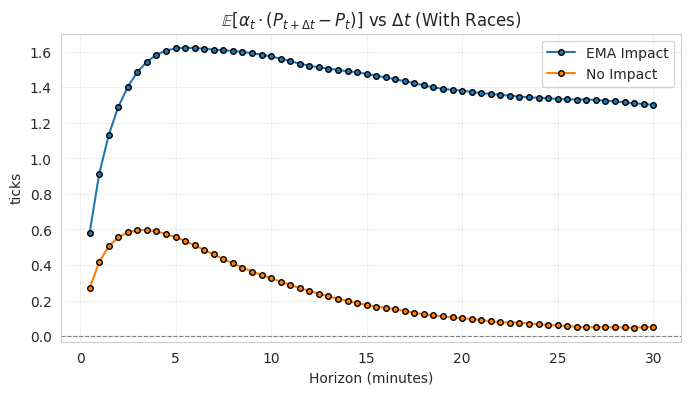

In [16]:
pnl = pl.read_csv("/home/labcmap/saad.souilmi/dev_cpp/qr/data/results/result_alpha_ema_impact_k1.0_race_pnl.csv")
pnlni = pl.read_csv("../data/results/result_alpha_no_impact_k1.0_race_pnl.csv")

# Plot
plt.figure(figsize=(8, 4))
plt.plot(
    pnl["lag_sec"] / 60,
    pnl["alpha_tickreturn_cov"],
    marker="o",
    ms=4,
    mec="k",
    lw=1.5,
    label="EMA Impact"
)
plt.plot(
    pnlni["lag_sec"] / 60,
    pnlni["alpha_tickreturn_cov"],
    marker="o",
    ms=4,
    mec="k",
    lw=1.5,
    label="No Impact"
)

plt.legend()
plt.xlabel("Horizon (minutes)")
plt.ylabel("ticks")
plt.title(
    r"$\mathbb{E}\left[\alpha_t \cdot \left(P_{t+\Delta t} - P_t\right)\right] \text{ vs } \Delta t$ (With Races)"
)
plt.axhline(0, color="gray", linestyle="--", lw=0.8)
plt.grid(True, alpha=0.3)
save_fig("alph_pnl")
plt.show()